In [ ]:
from active_critic.utils.gym_utils import make_vec_env, make_dummy_vec_env
import gym
from stable_baselines3 import PPO
import torch
import numpy as np
from stable_baselines3.common.vec_env import DummyVecEnv
from imitation.algorithms import bc
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
from stable_baselines3.common.evaluation import evaluate_policy
from utilsMW.dataLoaderMW import TorchDatasetMWToy
import warnings
from typing import Any, Dict, Optional, Type, Union

import numpy as np
import torch as th
from gym import spaces
from torch.nn import functional as F

from stable_baselines3.common.on_policy_algorithm import OnPolicyAlgorithm
from stable_baselines3.common.policies import ActorCriticCnnPolicy, ActorCriticPolicy, BasePolicy, MultiInputActorCriticPolicy
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, Schedule
from stable_baselines3.common.utils import explained_variance,  get_schedule_fn

from searchTest.toyEnvironment import check_outpt
from utilsMW.dataLoaderMW import TorchDatasetMW
from torch.utils.data import DataLoader
from imitation.algorithms.adversarial import gail 
from imitation.util.networks import RunningNorm
from imitation.rewards.reward_nets import BasicRewardNet
from stable_baselines3.ppo import MlpPolicy
from active_critic.utils.tboard_graphs import TBoardGraphs
def sample_expert_transitions(expert, env, num):

    rollouts = rollout.rollout(
        expert,
        env,
        rollout.make_sample_until(min_timesteps=None, min_episodes=num),
        exclude_infos=False,
    )
    return rollout.flatten_trajectories(rollouts), rollouts

def asd(env, learner):
    success = []
    rews = []
    for i in range(100):
        obs = env.reset()
        done = False
        while not done:
            action, _ = learner.predict(obs)
            obs, rew, done, info = env.step(action)
            rews.append(rew)
            if info[0]['success'] > 0:
                success.append(info[0]['success'])
                break
            if done:
                success.append(0)
    return np.array(success), np.array(rews)

from sb3_contrib import TQC
env, vec_expert = make_dummy_vec_env(name='pickplace', seq_len=200)
val_env, _ = make_dummy_vec_env(name='pickplace', seq_len=200)

policy_kwargs = dict(n_critics=2, n_quantiles=25)
learner = TQC("MlpPolicy", env, top_quantiles_to_drop_per_net=2, verbose=1, policy_kwargs=policy_kwargs)

tboard = TBoardGraphs(logname='TQC with expert Data', data_path='/data/bing/hendrik/gboard/')
learner.use_alt_policy = True
learner.alternative_policy = vec_expert
best_success = -1
for i in range(10000):
    learner.learn(5000, log_interval=1000)
    success, rews = asd(env=val_env, learner=learner)
    tboard.addTrainScalar('Reward', value=th.tensor(rews.mean()), stepid=env.envs[0].reset_count)
    mean_success = success.mean()
    tboard.addTrainScalar('Success Rate', value=th.tensor(mean_success), stepid=env.envs[0].reset_count)
    print(env.envs[0].reset_count)
    print(f'Success Rate: {mean_success}')
    if mean_success > best_success:
        learner.save('/data/bing/hendrik/reach_tqc')
        learner.save_replay_buffer('/databing/hendrik/reach_tqc_rpb')


In [ ]:
from sb3_contrib import TQC

tqc = TQC.load('/data/bing/hendrik/reatch_tqc.zip')

In [ ]:
tqc.load_replay_buffer('/data/bing/hendrik/reach_tqc_rpb.pkl')

In [12]:
from active_critic.utils.gym_utils import make_vec_env, make_dummy_vec_env
import gym
from stable_baselines3 import PPO
import torch
import numpy as np
from stable_baselines3.common.vec_env import DummyVecEnv
from imitation.algorithms import bc
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
from stable_baselines3.common.evaluation import evaluate_policy
from utilsMW.dataLoaderMW import TorchDatasetMWToy
import warnings
from typing import Any, Dict, Optional, Type, Union

import numpy as np
import torch as th
from gym import spaces
from torch.nn import functional as F

from stable_baselines3.common.on_policy_algorithm import OnPolicyAlgorithm
from stable_baselines3.common.policies import ActorCriticCnnPolicy, ActorCriticPolicy, BasePolicy, MultiInputActorCriticPolicy
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, Schedule
from stable_baselines3.common.utils import explained_variance,  get_schedule_fn

from searchTest.toyEnvironment import check_outpt
from utilsMW.dataLoaderMW import TorchDatasetMW
from torch.utils.data import DataLoader
from imitation.algorithms.adversarial import gail 
from imitation.util.networks import RunningNorm
from imitation.rewards.reward_nets import BasicRewardNet
from stable_baselines3.ppo import MlpPolicy
from active_critic.utils.tboard_graphs import TBoardGraphs
from active_critic.model_src.transformer import PositionalEncoding

import copy

from active_critic.utils.gym_utils import make_policy_dict, ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE, ResetCounterWrapper, TimeLimit, StrictSeqLenWrapper, ImitationLearningWrapper



class POMDP_Wrapper(gym.Wrapper):
    def __init__(self, env, lookup_freq, pe_dim, seq_len) -> None:
        super().__init__(env)
        inpt = th.zeros([1, seq_len, pe_dim])
        positional_encoding = PositionalEncoding(d_model=10, dropout=0)
        self.pe = positional_encoding.forward(inpt).numpy()
        self.current_step = 0
        self.lookup_freq = lookup_freq

    def reset(self):
        obsv =  super().reset()
        obsv[20:30] = self.pe[0, 0]
        self.current_step = 0
        self.current_obv = np.copy(obsv)
        return obsv

    def step(self, action):
        self.current_step += 1
        obsv, rew, done, info = super().step(action)
        if self.current_step % self.lookup_freq == 0:
            self.current_obv = np.copy(obsv)
        
        obsv = np.copy(self.current_obv)
        obsv[20:30] = self.pe[0, self.current_step]

        return obsv, rew, done, info

def make_dummy_vec_env_pomdp(name, seq_len, lookup_freq):
    policy_dict = make_policy_dict()

    env_tag = name
    max_episode_steps = seq_len
    env = ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE[policy_dict[env_tag][1]]()
    env._freeze_rand_vec = False
    reset_env = ResetCounterWrapper(env=env)
    timelimit = TimeLimit(env=reset_env, max_episode_steps=max_episode_steps)
    strict_time = StrictSeqLenWrapper(timelimit, seq_len=seq_len + 1)
    pomdp = POMDP_Wrapper(env=strict_time, lookup_freq=lookup_freq, pe_dim=10, seq_len=201)

    dv1 = DummyVecEnv([lambda: RolloutInfoWrapper(pomdp)])
    vec_expert = ImitationLearningWrapper(
        policy=policy_dict[env_tag][0], env=dv1)
    return dv1, vec_expert

def asd(env, learner):
    success = []
    rews = []
    for i in range(100):
        obs = env.reset()
        done = False
        while not done:
            action, _ = learner.predict(obs)
            obs, rew, done, info = env.step(action)
            rews.append(rew)
            if info[0]['success'] > 0:
                success.append(info[0]['success'])
                break
            if done:
                success.append(0)
    return np.array(success), np.array(rews)

def sample_expert_transitions(expert, env, num):

    rollouts = rollout.rollout(
        expert,
        env,
        rollout.make_sample_until(min_timesteps=None, min_episodes=num),
        exclude_infos=False,
    )
    return rollout.flatten_trajectories(rollouts), rollouts

def make_pomdp_rollouts(rollouts, lookup_frq, count_dim):
    inpt = th.zeros([1, rollouts[0].obs.shape[0], count_dim])
    positional_encoding = PositionalEncoding(d_model=10, dropout=0)
    pe = positional_encoding.forward(inpt).numpy()
    for ro in rollouts:
        for i in range(ro.obs.shape[0]):
            if i % lookup_frq == 0:
                obsv = copy.deepcopy(ro.obs[i])
            else:
                ro.obs[i] = copy.deepcopy(obsv)
        ro.obs[:, 20:20+count_dim] = pe
        if i % lookup_frq == 0:
            obs = ro
    return rollouts

def run_experiment(device):
    lookup_freq = 50
    env, vec_expert = make_dummy_vec_env(name='pickplace', seq_len=200)
    val_env, _ = make_dummy_vec_env(name='pickplace', seq_len=200)

    transitions, rollouts = sample_expert_transitions(vec_expert.predict, env, 10)
    env.envs[0].reset_count = 0
    pomdp_rollouts = make_pomdp_rollouts(rollouts, lookup_frq=lookup_freq, count_dim=10)
    pomdp_transitions = rollout.flatten_trajectories(pomdp_rollouts)

    pomdp_env, pomdp_vec_expert = make_dummy_vec_env_pomdp(name='pickplace', seq_len=200, lookup_freq=lookup_freq)

    bc_trainer = bc.BC(
        observation_space=env.observation_space,
        action_space=env.action_space,
        demonstrations=pomdp_transitions,
        device=device
    )

    tboard = TBoardGraphs(logname='BC pickplace 10 lookup '+str(lookup_freq) , data_path='/data/bing/hendrik/gboard/')
    for i in range(10000):
        bc_trainer.train(n_epochs=20)
        success, rews = asd(env=pomdp_env, learner=bc_trainer.policy)
        tboard.addTrainScalar('Reward', value=th.tensor(rews.mean()), stepid=i)
        tboard.addTrainScalar('Success Rate', value=th.tensor(success.mean()), stepid=i)
    

/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/hendrik/Documents/master_project/Code/MetaWorld/metaworld/policies/policy.py:41: UserWarning: Constant(s) may be too high. Environments clip response to [-1, 1]
  warnings.warn('Constant(s) may be too high. Environments clip response to [-1, 1]')
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -0.00568 |
|    entropy        | 5.68     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 64.5     |
|    loss           | 4.21     |
|    neglogp        | 4.21     |
|    prob_true_act  | 0.0149   |
|    samples_so_far | 32       |
--------------------------------


490batch [00:01, 318.41batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | -0.00363 |
|    entropy        | 3.63     |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 84.1     |
|    loss           | 1.77     |
|    neglogp        | 1.78     |
|    prob_true_act  | 0.175    |
|    samples_so_far | 16032    |
--------------------------------


974batch [00:03, 319.51batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | -0.00173 |
|    entropy        | 1.73     |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 101      |
|    loss           | 0.0838   |
|    neglogp        | 0.0855   |
|    prob_true_act  | 1.08     |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 320.67batch/s]
0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000891 |
|    entropy        | 0.891     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 112       |
|    loss           | -0.44     |
|    neglogp        | -0.439    |
|    prob_true_act  | 2.34      |
|    samples_so_far | 32        |
---------------------------------


466batch [00:01, 312.58batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.000618 |
|    entropy        | -0.618   |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 135      |
|    loss           | -1.22    |
|    neglogp        | -1.22    |
|    prob_true_act  | 8.36     |
|    samples_so_far | 16032    |
--------------------------------


970batch [00:02, 316.11batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.0017   |
|    entropy        | -1.7     |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 157      |
|    loss           | -2.81    |
|    neglogp        | -2.81    |
|    prob_true_act  | 27.9     |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 328.07batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00204  |
|    entropy        | -2.04    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 167      |
|    loss           | -1.1     |
|    neglogp        | -1.1     |
|    prob_true_act  | 37.4     |
|    samples_so_far | 32       |
--------------------------------


500batch [00:01, 341.49batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00254  |
|    entropy        | -2.54    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 187      |
|    loss           | -3.52    |
|    neglogp        | -3.52    |
|    prob_true_act  | 69.8     |
|    samples_so_far | 16032    |
--------------------------------


980batch [00:02, 310.31batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00284  |
|    entropy        | -2.84    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 206      |
|    loss           | -2.04    |
|    neglogp        | -2.04    |
|    prob_true_act  | 86.3     |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 326.97batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00296  |
|    entropy        | -2.96    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | -3.53    |
|    neglogp        | -3.53    |
|    prob_true_act  | 98.5     |
|    samples_so_far | 32       |
--------------------------------


470batch [00:01, 304.54batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00323  |
|    entropy        | -3.23    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 235      |
|    loss           | -4.41    |
|    neglogp        | -4.41    |
|    prob_true_act  | 126      |
|    samples_so_far | 16032    |
--------------------------------


970batch [00:03, 307.29batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00351  |
|    entropy        | -3.51    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 253      |
|    loss           | -4.68    |
|    neglogp        | -4.69    |
|    prob_true_act  | 182      |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:04, 307.89batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00365  |
|    entropy        | -3.65    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 261      |
|    loss           | -2.38    |
|    neglogp        | -2.38    |
|    prob_true_act  | 180      |
|    samples_so_far | 32       |
--------------------------------


493batch [00:01, 329.81batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00393  |
|    entropy        | -3.93    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 276      |
|    loss           | -2.48    |
|    neglogp        | -2.49    |
|    prob_true_act  | 235      |
|    samples_so_far | 16032    |
--------------------------------


994batch [00:02, 329.21batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00413  |
|    entropy        | -4.13    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 289      |
|    loss           | -5.7     |
|    neglogp        | -5.71    |
|    prob_true_act  | 350      |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 335.83batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00422  |
|    entropy        | -4.22    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 295      |
|    loss           | -2.59    |
|    neglogp        | -2.6     |
|    prob_true_act  | 312      |
|    samples_so_far | 32       |
--------------------------------


474batch [00:01, 311.07batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00438  |
|    entropy        | -4.38    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 307      |
|    loss           | -5.02    |
|    neglogp        | -5.02    |
|    prob_true_act  | 442      |
|    samples_so_far | 16032    |
--------------------------------


997batch [00:03, 334.01batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00452  |
|    entropy        | -4.52    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 317      |
|    loss           | -0.944   |
|    neglogp        | -0.949   |
|    prob_true_act  | 382      |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 318.46batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00457  |
|    entropy        | -4.57    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 321      |
|    loss           | -4.67    |
|    neglogp        | -4.68    |
|    prob_true_act  | 367      |
|    samples_so_far | 32       |
--------------------------------


494batch [00:01, 329.96batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00467  |
|    entropy        | -4.67    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 330      |
|    loss           | -5.43    |
|    neglogp        | -5.43    |
|    prob_true_act  | 573      |
|    samples_so_far | 16032    |
--------------------------------


963batch [00:02, 366.13batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00478  |
|    entropy        | -4.78    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 339      |
|    loss           | -0.949   |
|    neglogp        | -0.954   |
|    prob_true_act  | 512      |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 343.61batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00482  |
|    entropy        | -4.82    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 343      |
|    loss           | -4.59    |
|    neglogp        | -4.59    |
|    prob_true_act  | 607      |
|    samples_so_far | 32       |
--------------------------------


468batch [00:01, 320.44batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00489  |
|    entropy        | -4.89    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 352      |
|    loss           | -6.07    |
|    neglogp        | -6.07    |
|    prob_true_act  | 671      |
|    samples_so_far | 16032    |
--------------------------------


969batch [00:02, 351.51batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00499  |
|    entropy        | -4.99    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 360      |
|    loss           | -5.81    |
|    neglogp        | -5.81    |
|    prob_true_act  | 697      |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 320.98batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00502  |
|    entropy        | -5.02    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 364      |
|    loss           | -4.71    |
|    neglogp        | -4.72    |
|    prob_true_act  | 673      |
|    samples_so_far | 32       |
--------------------------------


482batch [00:01, 326.38batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00509  |
|    entropy        | -5.09    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 372      |
|    loss           | 2.48     |
|    neglogp        | 2.47     |
|    prob_true_act  | 681      |
|    samples_so_far | 16032    |
--------------------------------


969batch [00:02, 326.23batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00516  |
|    entropy        | -5.16    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 380      |
|    loss           | -5.83    |
|    neglogp        | -5.84    |
|    prob_true_act  | 830      |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 332.98batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.0052   |
|    entropy        | -5.2     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 384      |
|    loss           | -5.69    |
|    neglogp        | -5.7     |
|    prob_true_act  | 836      |
|    samples_so_far | 32       |
--------------------------------


478batch [00:01, 332.21batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00528  |
|    entropy        | -5.28    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 393      |
|    loss           | -2.87    |
|    neglogp        | -2.88    |
|    prob_true_act  | 1.1e+03  |
|    samples_so_far | 16032    |
--------------------------------


988batch [00:03, 321.92batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00529  |
|    entropy        | -5.29    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 401      |
|    loss           | -6.77    |
|    neglogp        | -6.77    |
|    prob_true_act  | 1e+03    |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 327.23batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00533  |
|    entropy        | -5.33    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 404      |
|    loss           | -5.4     |
|    neglogp        | -5.4     |
|    prob_true_act  | 847      |
|    samples_so_far | 32       |
--------------------------------


470batch [00:01, 349.88batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00543  |
|    entropy        | -5.43    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 413      |
|    loss           | -6.71    |
|    neglogp        | -6.71    |
|    prob_true_act  | 1.23e+03 |
|    samples_so_far | 16032    |
--------------------------------


1000batch [00:02, 331.81batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00549  |
|    entropy        | -5.49    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 421      |
|    loss           | -7.07    |
|    neglogp        | -7.07    |
|    prob_true_act  | 1.38e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 331.58batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00552  |
|    entropy        | -5.52    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 424      |
|    loss           | -6.79    |
|    neglogp        | -6.8     |
|    prob_true_act  | 1.26e+03 |
|    samples_so_far | 32       |
--------------------------------


495batch [00:01, 356.76batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00555  |
|    entropy        | -5.55    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 432      |
|    loss           | -6.9     |
|    neglogp        | -6.91    |
|    prob_true_act  | 1.32e+03 |
|    samples_so_far | 16032    |
--------------------------------


974batch [00:02, 332.09batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.0056   |
|    entropy        | -5.6     |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 439      |
|    loss           | -7.09    |
|    neglogp        | -7.1     |
|    prob_true_act  | 1.43e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 341.61batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00561  |
|    entropy        | -5.61    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 442      |
|    loss           | -6.25    |
|    neglogp        | -6.26    |
|    prob_true_act  | 1.22e+03 |
|    samples_so_far | 32       |
--------------------------------


494batch [00:01, 315.47batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00564  |
|    entropy        | -5.64    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 450      |
|    loss           | -6.91    |
|    neglogp        | -6.91    |
|    prob_true_act  | 1.5e+03  |
|    samples_so_far | 16032    |
--------------------------------


983batch [00:03, 323.11batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00565  |
|    entropy        | -5.65    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 457      |
|    loss           | -6.4     |
|    neglogp        | -6.41    |
|    prob_true_act  | 1.41e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 320.16batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00567  |
|    entropy        | -5.67    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 460      |
|    loss           | -7.08    |
|    neglogp        | -7.08    |
|    prob_true_act  | 1.37e+03 |
|    samples_so_far | 32       |
--------------------------------


489batch [00:01, 363.98batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.0057   |
|    entropy        | -5.7     |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 467      |
|    loss           | -6.4     |
|    neglogp        | -6.41    |
|    prob_true_act  | 1.58e+03 |
|    samples_so_far | 16032    |
--------------------------------


974batch [00:02, 323.53batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00574  |
|    entropy        | -5.74    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 473      |
|    loss           | -7.04    |
|    neglogp        | -7.04    |
|    prob_true_act  | 1.42e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 338.85batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00576  |
|    entropy        | -5.76    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 477      |
|    loss           | -7.16    |
|    neglogp        | -7.17    |
|    prob_true_act  | 1.65e+03 |
|    samples_so_far | 32       |
--------------------------------


483batch [00:01, 341.92batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.0058   |
|    entropy        | -5.8     |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 483      |
|    loss           | -5.25    |
|    neglogp        | -5.25    |
|    prob_true_act  | 1.61e+03 |
|    samples_so_far | 16032    |
--------------------------------


991batch [00:02, 308.86batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.0058   |
|    entropy        | -5.8     |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 490      |
|    loss           | -7.09    |
|    neglogp        | -7.1     |
|    prob_true_act  | 1.72e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 332.97batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00581  |
|    entropy        | -5.81    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 493      |
|    loss           | -7.54    |
|    neglogp        | -7.55    |
|    prob_true_act  | 1.99e+03 |
|    samples_so_far | 32       |
--------------------------------


475batch [00:01, 339.51batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00586  |
|    entropy        | -5.86    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 500      |
|    loss           | -6.62    |
|    neglogp        | -6.63    |
|    prob_true_act  | 1.3e+03  |
|    samples_so_far | 16032    |
--------------------------------


976batch [00:02, 343.73batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00583  |
|    entropy        | -5.83    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 506      |
|    loss           | -4.24    |
|    neglogp        | -4.25    |
|    prob_true_act  | 1.32e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 335.01batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00586  |
|    entropy        | -5.86    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 509      |
|    loss           | -7.1     |
|    neglogp        | -7.11    |
|    prob_true_act  | 1.68e+03 |
|    samples_so_far | 32       |
--------------------------------


497batch [00:01, 361.92batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00594  |
|    entropy        | -5.94    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 515      |
|    loss           | 1.27     |
|    neglogp        | 1.26     |
|    prob_true_act  | 1.97e+03 |
|    samples_so_far | 16032    |
--------------------------------


997batch [00:02, 321.78batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00597  |
|    entropy        | -5.97    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 522      |
|    loss           | -6.97    |
|    neglogp        | -6.98    |
|    prob_true_act  | 1.83e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 335.78batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00598  |
|    entropy        | -5.98    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 525      |
|    loss           | -7.66    |
|    neglogp        | -7.67    |
|    prob_true_act  | 2.27e+03 |
|    samples_so_far | 32       |
--------------------------------


483batch [00:01, 320.92batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00599  |
|    entropy        | -5.99    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 532      |
|    loss           | -6.36    |
|    neglogp        | -6.37    |
|    prob_true_act  | 1.88e+03 |
|    samples_so_far | 16032    |
--------------------------------


993batch [00:03, 322.15batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.006    |
|    entropy        | -6       |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 539      |
|    loss           | -7.29    |
|    neglogp        | -7.3     |
|    prob_true_act  | 1.86e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 319.84batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.006    |
|    entropy        | -6       |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 541      |
|    loss           | -7.29    |
|    neglogp        | -7.29    |
|    prob_true_act  | 1.97e+03 |
|    samples_so_far | 32       |
--------------------------------


484batch [00:01, 302.56batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00605  |
|    entropy        | -6.05    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 548      |
|    loss           | -7.23    |
|    neglogp        | -7.24    |
|    prob_true_act  | 1.99e+03 |
|    samples_so_far | 16032    |
--------------------------------


974batch [00:03, 349.99batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00607  |
|    entropy        | -6.07    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 555      |
|    loss           | -7.02    |
|    neglogp        | -7.03    |
|    prob_true_act  | 2.26e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 326.64batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00608  |
|    entropy        | -6.08    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 558      |
|    loss           | -6.86    |
|    neglogp        | -6.86    |
|    prob_true_act  | 1.97e+03 |
|    samples_so_far | 32       |
--------------------------------


475batch [00:01, 350.40batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00611  |
|    entropy        | -6.11    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 565      |
|    loss           | -6.91    |
|    neglogp        | -6.92    |
|    prob_true_act  | 2.14e+03 |
|    samples_so_far | 16032    |
--------------------------------


970batch [00:02, 309.60batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00613  |
|    entropy        | -6.13    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 572      |
|    loss           | -7.27    |
|    neglogp        | -7.28    |
|    prob_true_act  | 2.29e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 329.46batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00612  |
|    entropy        | -6.12    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 575      |
|    loss           | -7.09    |
|    neglogp        | -7.1     |
|    prob_true_act  | 2.46e+03 |
|    samples_so_far | 32       |
--------------------------------


478batch [00:01, 303.83batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00618  |
|    entropy        | -6.18    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 581      |
|    loss           | -7.04    |
|    neglogp        | -7.05    |
|    prob_true_act  | 2.2e+03  |
|    samples_so_far | 16032    |
--------------------------------


996batch [00:03, 313.27batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00618  |
|    entropy        | -6.18    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 588      |
|    loss           | -3.84    |
|    neglogp        | -3.85    |
|    prob_true_act  | 2.23e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 324.93batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00618  |
|    entropy        | -6.18    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 592      |
|    loss           | -6.58    |
|    neglogp        | -6.59    |
|    prob_true_act  | 2.45e+03 |
|    samples_so_far | 32       |
--------------------------------


494batch [00:01, 312.47batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00619  |
|    entropy        | -6.19    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 598      |
|    loss           | -7.5     |
|    neglogp        | -7.5     |
|    prob_true_act  | 2.78e+03 |
|    samples_so_far | 16032    |
--------------------------------


998batch [00:02, 354.00batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00624  |
|    entropy        | -6.24    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 605      |
|    loss           | -4.42    |
|    neglogp        | -4.42    |
|    prob_true_act  | 2.22e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 333.77batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00624  |
|    entropy        | -6.24    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 608      |
|    loss           | -7.03    |
|    neglogp        | -7.04    |
|    prob_true_act  | 2.54e+03 |
|    samples_so_far | 32       |
--------------------------------


492batch [00:01, 342.96batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00627  |
|    entropy        | -6.27    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 615      |
|    loss           | -2.78    |
|    neglogp        | -2.79    |
|    prob_true_act  | 2.77e+03 |
|    samples_so_far | 16032    |
--------------------------------


971batch [00:03, 353.83batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00628  |
|    entropy        | -6.28    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 622      |
|    loss           | -5.9     |
|    neglogp        | -5.9     |
|    prob_true_act  | 2.38e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 319.14batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00629  |
|    entropy        | -6.29    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 625      |
|    loss           | -6.42    |
|    neglogp        | -6.43    |
|    prob_true_act  | 2.94e+03 |
|    samples_so_far | 32       |
--------------------------------


490batch [00:01, 316.30batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00631  |
|    entropy        | -6.31    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 632      |
|    loss           | -6.62    |
|    neglogp        | -6.62    |
|    prob_true_act  | 2.62e+03 |
|    samples_so_far | 16032    |
--------------------------------


978batch [00:03, 304.94batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00633  |
|    entropy        | -6.33    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 639      |
|    loss           | -7.9     |
|    neglogp        | -7.91    |
|    prob_true_act  | 2.94e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 315.27batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00632  |
|    entropy        | -6.32    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 642      |
|    loss           | -7.74    |
|    neglogp        | -7.75    |
|    prob_true_act  | 2.84e+03 |
|    samples_so_far | 32       |
--------------------------------


485batch [00:01, 315.61batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00635  |
|    entropy        | -6.35    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 649      |
|    loss           | -6.05    |
|    neglogp        | -6.06    |
|    prob_true_act  | 2.55e+03 |
|    samples_so_far | 16032    |
--------------------------------


972batch [00:03, 321.02batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00637  |
|    entropy        | -6.37    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 656      |
|    loss           | -7.36    |
|    neglogp        | -7.37    |
|    prob_true_act  | 3.36e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 314.68batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.0064   |
|    entropy        | -6.4     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 659      |
|    loss           | -5.05    |
|    neglogp        | -5.05    |
|    prob_true_act  | 3.25e+03 |
|    samples_so_far | 32       |
--------------------------------


497batch [00:01, 334.03batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.0064   |
|    entropy        | -6.4     |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 666      |
|    loss           | -7.73    |
|    neglogp        | -7.74    |
|    prob_true_act  | 2.86e+03 |
|    samples_so_far | 16032    |
--------------------------------


995batch [00:03, 317.14batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.0064   |
|    entropy        | -6.4     |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 673      |
|    loss           | -6.92    |
|    neglogp        | -6.93    |
|    prob_true_act  | 2.56e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 326.77batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00642  |
|    entropy        | -6.42    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 676      |
|    loss           | -5.41    |
|    neglogp        | -5.42    |
|    prob_true_act  | 2.88e+03 |
|    samples_so_far | 32       |
--------------------------------


496batch [00:01, 309.99batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.0065   |
|    entropy        | -6.5     |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 683      |
|    loss           | -6.99    |
|    neglogp        | -7       |
|    prob_true_act  | 3.64e+03 |
|    samples_so_far | 16032    |
--------------------------------


974batch [00:03, 341.54batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.0065   |
|    entropy        | -6.5     |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 690      |
|    loss           | -4.47    |
|    neglogp        | -4.47    |
|    prob_true_act  | 3.62e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 323.69batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00648  |
|    entropy        | -6.48    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 693      |
|    loss           | -7.84    |
|    neglogp        | -7.85    |
|    prob_true_act  | 3.35e+03 |
|    samples_so_far | 32       |
--------------------------------


497batch [00:01, 314.95batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00648  |
|    entropy        | -6.48    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 700      |
|    loss           | -5.45    |
|    neglogp        | -5.46    |
|    prob_true_act  | 3.1e+03  |
|    samples_so_far | 16032    |
--------------------------------


991batch [00:03, 335.14batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00646  |
|    entropy        | -6.46    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 707      |
|    loss           | -5.89    |
|    neglogp        | -5.9     |
|    prob_true_act  | 2.98e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 321.43batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00647  |
|    entropy        | -6.47    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 711      |
|    loss           | -7.49    |
|    neglogp        | -7.5     |
|    prob_true_act  | 3.15e+03 |
|    samples_so_far | 32       |
--------------------------------


472batch [00:01, 356.96batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00654  |
|    entropy        | -6.54    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 718      |
|    loss           | -8.3     |
|    neglogp        | -8.3     |
|    prob_true_act  | 4.22e+03 |
|    samples_so_far | 16032    |
--------------------------------


977batch [00:03, 328.03batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.0066   |
|    entropy        | -6.6     |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 725      |
|    loss           | -0.798   |
|    neglogp        | -0.804   |
|    prob_true_act  | 3.48e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 323.98batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00661  |
|    entropy        | -6.61    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 729      |
|    loss           | -8.13    |
|    neglogp        | -8.13    |
|    prob_true_act  | 3.88e+03 |
|    samples_so_far | 32       |
--------------------------------


478batch [00:01, 308.10batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.0066   |
|    entropy        | -6.6     |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 736      |
|    loss           | -8       |
|    neglogp        | -8.01    |
|    prob_true_act  | 3.67e+03 |
|    samples_so_far | 16032    |
--------------------------------


983batch [00:03, 308.74batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00663  |
|    entropy        | -6.63    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 743      |
|    loss           | -5.6     |
|    neglogp        | -5.61    |
|    prob_true_act  | 3.99e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:04, 306.52batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00667  |
|    entropy        | -6.67    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 747      |
|    loss           | -7.87    |
|    neglogp        | -7.88    |
|    prob_true_act  | 3.64e+03 |
|    samples_so_far | 32       |
--------------------------------


470batch [00:01, 316.60batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00667  |
|    entropy        | -6.67    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 754      |
|    loss           | -7.98    |
|    neglogp        | -7.99    |
|    prob_true_act  | 3.51e+03 |
|    samples_so_far | 16032    |
--------------------------------


986batch [00:03, 311.96batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00669  |
|    entropy        | -6.69    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 761      |
|    loss           | -7.91    |
|    neglogp        | -7.92    |
|    prob_true_act  | 4.33e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:04, 309.57batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00671  |
|    entropy        | -6.71    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 765      |
|    loss           | -7.56    |
|    neglogp        | -7.57    |
|    prob_true_act  | 3.81e+03 |
|    samples_so_far | 32       |
--------------------------------


476batch [00:01, 310.29batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00671  |
|    entropy        | -6.71    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 772      |
|    loss           | -7.5     |
|    neglogp        | -7.5     |
|    prob_true_act  | 3.57e+03 |
|    samples_so_far | 16032    |
--------------------------------


989batch [00:03, 324.38batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00672  |
|    entropy        | -6.72    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 779      |
|    loss           | -6.83    |
|    neglogp        | -6.84    |
|    prob_true_act  | 3.68e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 315.55batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00675  |
|    entropy        | -6.75    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 783      |
|    loss           | -7.55    |
|    neglogp        | -7.55    |
|    prob_true_act  | 3.97e+03 |
|    samples_so_far | 32       |
--------------------------------


475batch [00:01, 319.21batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00676  |
|    entropy        | -6.76    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 790      |
|    loss           | -7.59    |
|    neglogp        | -7.6     |
|    prob_true_act  | 3.55e+03 |
|    samples_so_far | 16032    |
--------------------------------


983batch [00:03, 304.67batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00679  |
|    entropy        | -6.79    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 797      |
|    loss           | -8.18    |
|    neglogp        | -8.19    |
|    prob_true_act  | 4.61e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 313.75batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00681  |
|    entropy        | -6.81    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 801      |
|    loss           | -8.29    |
|    neglogp        | -8.29    |
|    prob_true_act  | 4.81e+03 |
|    samples_so_far | 32       |
--------------------------------


483batch [00:01, 313.19batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00682  |
|    entropy        | -6.82    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 808      |
|    loss           | -7.98    |
|    neglogp        | -7.99    |
|    prob_true_act  | 4.28e+03 |
|    samples_so_far | 16032    |
--------------------------------


976batch [00:03, 313.45batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00684  |
|    entropy        | -6.84    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 815      |
|    loss           | -8.08    |
|    neglogp        | -8.09    |
|    prob_true_act  | 4.78e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 322.06batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00688  |
|    entropy        | -6.88    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 819      |
|    loss           | -5.83    |
|    neglogp        | -5.84    |
|    prob_true_act  | 3.95e+03 |
|    samples_so_far | 32       |
--------------------------------


483batch [00:01, 318.86batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00688  |
|    entropy        | -6.88    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 826      |
|    loss           | -8.4     |
|    neglogp        | -8.41    |
|    prob_true_act  | 5.27e+03 |
|    samples_so_far | 16032    |
--------------------------------


980batch [00:03, 333.17batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00688  |
|    entropy        | -6.88    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 833      |
|    loss           | -6.75    |
|    neglogp        | -6.75    |
|    prob_true_act  | 4.41e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 317.00batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00689  |
|    entropy        | -6.89    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 837      |
|    loss           | -7.57    |
|    neglogp        | -7.57    |
|    prob_true_act  | 4.01e+03 |
|    samples_so_far | 32       |
--------------------------------


498batch [00:01, 341.18batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00691  |
|    entropy        | -6.91    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 844      |
|    loss           | -7.95    |
|    neglogp        | -7.96    |
|    prob_true_act  | 4.66e+03 |
|    samples_so_far | 16032    |
--------------------------------


972batch [00:02, 345.88batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00693  |
|    entropy        | -6.93    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 852      |
|    loss           | -6.52    |
|    neglogp        | -6.53    |
|    prob_true_act  | 4.68e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 340.50batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00695  |
|    entropy        | -6.95    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 855      |
|    loss           | -7.41    |
|    neglogp        | -7.41    |
|    prob_true_act  | 5.11e+03 |
|    samples_so_far | 32       |
--------------------------------


494batch [00:01, 322.20batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00695  |
|    entropy        | -6.95    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 863      |
|    loss           | -8.23    |
|    neglogp        | -8.24    |
|    prob_true_act  | 4.98e+03 |
|    samples_so_far | 16032    |
--------------------------------


985batch [00:03, 343.61batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00699  |
|    entropy        | -6.99    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 871      |
|    loss           | -7.84    |
|    neglogp        | -7.84    |
|    prob_true_act  | 5.36e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 325.17batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.007    |
|    entropy        | -7       |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 875      |
|    loss           | -6.73    |
|    neglogp        | -6.74    |
|    prob_true_act  | 4.94e+03 |
|    samples_so_far | 32       |
--------------------------------


483batch [00:01, 313.29batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00693  |
|    entropy        | -6.93    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 882      |
|    loss           | -8.47    |
|    neglogp        | -8.48    |
|    prob_true_act  | 5.24e+03 |
|    samples_so_far | 16032    |
--------------------------------


991batch [00:03, 311.85batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00702  |
|    entropy        | -7.02    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 889      |
|    loss           | -8.11    |
|    neglogp        | -8.12    |
|    prob_true_act  | 5.09e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 316.02batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00706  |
|    entropy        | -7.06    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 893      |
|    loss           | -8.43    |
|    neglogp        | -8.44    |
|    prob_true_act  | 5.83e+03 |
|    samples_so_far | 32       |
--------------------------------


490batch [00:01, 320.81batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00707  |
|    entropy        | -7.07    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 901      |
|    loss           | -7.77    |
|    neglogp        | -7.78    |
|    prob_true_act  | 4.36e+03 |
|    samples_so_far | 16032    |
--------------------------------


998batch [00:03, 327.65batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00711  |
|    entropy        | -7.11    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 909      |
|    loss           | -8.79    |
|    neglogp        | -8.8     |
|    prob_true_act  | 7.25e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 328.36batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00705  |
|    entropy        | -7.05    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 912      |
|    loss           | -7.14    |
|    neglogp        | -7.15    |
|    prob_true_act  | 5.31e+03 |
|    samples_so_far | 32       |
--------------------------------


466batch [00:01, 332.63batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.0071   |
|    entropy        | -7.1     |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 920      |
|    loss           | -7.97    |
|    neglogp        | -7.98    |
|    prob_true_act  | 5.49e+03 |
|    samples_so_far | 16032    |
--------------------------------


976batch [00:02, 326.54batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00713  |
|    entropy        | -7.13    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 928      |
|    loss           | -5.68    |
|    neglogp        | -5.69    |
|    prob_true_act  | 3.9e+03  |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 335.22batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00715  |
|    entropy        | -7.15    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 932      |
|    loss           | -8.27    |
|    neglogp        | -8.28    |
|    prob_true_act  | 6.38e+03 |
|    samples_so_far | 32       |
--------------------------------


472batch [00:01, 321.15batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00716  |
|    entropy        | -7.16    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 940      |
|    loss           | -7.31    |
|    neglogp        | -7.32    |
|    prob_true_act  | 6.14e+03 |
|    samples_so_far | 16032    |
--------------------------------


992batch [00:03, 310.43batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00718  |
|    entropy        | -7.18    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 948      |
|    loss           | -6.05    |
|    neglogp        | -6.06    |
|    prob_true_act  | 6.93e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 323.39batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00716  |
|    entropy        | -7.16    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 951      |
|    loss           | -4.94    |
|    neglogp        | -4.94    |
|    prob_true_act  | 5.95e+03 |
|    samples_so_far | 32       |
--------------------------------


496batch [00:01, 336.07batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00721  |
|    entropy        | -7.21    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 959      |
|    loss           | -7.91    |
|    neglogp        | -7.92    |
|    prob_true_act  | 4.78e+03 |
|    samples_so_far | 16032    |
--------------------------------


994batch [00:03, 311.77batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00721  |
|    entropy        | -7.21    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 967      |
|    loss           | -8.57    |
|    neglogp        | -8.58    |
|    prob_true_act  | 7.08e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 317.05batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00723  |
|    entropy        | -7.23    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 970      |
|    loss           | -6.96    |
|    neglogp        | -6.96    |
|    prob_true_act  | 6.76e+03 |
|    samples_so_far | 32       |
--------------------------------


498batch [00:01, 312.00batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00726  |
|    entropy        | -7.26    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 978      |
|    loss           | -8.21    |
|    neglogp        | -8.22    |
|    prob_true_act  | 6.62e+03 |
|    samples_so_far | 16032    |
--------------------------------


975batch [00:03, 313.81batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.0073   |
|    entropy        | -7.3     |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 986      |
|    loss           | -7.49    |
|    neglogp        | -7.49    |
|    prob_true_act  | 5.98e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 317.25batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.0073   |
|    entropy        | -7.3     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 990      |
|    loss           | -8.36    |
|    neglogp        | -8.37    |
|    prob_true_act  | 6.99e+03 |
|    samples_so_far | 32       |
--------------------------------


477batch [00:01, 315.18batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00728  |
|    entropy        | -7.28    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 998      |
|    loss           | -6.78    |
|    neglogp        | -6.79    |
|    prob_true_act  | 6.89e+03 |
|    samples_so_far | 16032    |
--------------------------------


975batch [00:03, 329.71batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00729  |
|    entropy        | -7.29    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 1.01e+03 |
|    loss           | -8.81    |
|    neglogp        | -8.81    |
|    prob_true_act  | 7.98e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 310.81batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00724  |
|    entropy        | -7.24    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 1.01e+03 |
|    loss           | -8.33    |
|    neglogp        | -8.33    |
|    prob_true_act  | 7.42e+03 |
|    samples_so_far | 32       |
--------------------------------


495batch [00:01, 306.38batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00728  |
|    entropy        | -7.28    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 1.02e+03 |
|    loss           | -5.88    |
|    neglogp        | -5.89    |
|    prob_true_act  | 6.11e+03 |
|    samples_so_far | 16032    |
--------------------------------


978batch [00:03, 309.37batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00733  |
|    entropy        | -7.33    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 1.03e+03 |
|    loss           | -4.67    |
|    neglogp        | -4.68    |
|    prob_true_act  | 6.25e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:04, 307.82batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00735  |
|    entropy        | -7.35    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 1.03e+03 |
|    loss           | -7.74    |
|    neglogp        | -7.75    |
|    prob_true_act  | 7.08e+03 |
|    samples_so_far | 32       |
--------------------------------


486batch [00:01, 311.46batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.0074   |
|    entropy        | -7.4     |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 1.04e+03 |
|    loss           | -7.84    |
|    neglogp        | -7.85    |
|    prob_true_act  | 6.46e+03 |
|    samples_so_far | 16032    |
--------------------------------


968batch [00:03, 307.90batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00738  |
|    entropy        | -7.38    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 1.04e+03 |
|    loss           | -8.19    |
|    neglogp        | -8.2     |
|    prob_true_act  | 7.38e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 315.62batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00742  |
|    entropy        | -7.42    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 1.05e+03 |
|    loss           | -8.68    |
|    neglogp        | -8.68    |
|    prob_true_act  | 8.14e+03 |
|    samples_so_far | 32       |
--------------------------------


477batch [00:01, 304.04batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00744  |
|    entropy        | -7.44    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 1.06e+03 |
|    loss           | -8.33    |
|    neglogp        | -8.33    |
|    prob_true_act  | 7.95e+03 |
|    samples_so_far | 16032    |
--------------------------------


981batch [00:03, 311.33batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00749  |
|    entropy        | -7.49    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 1.06e+03 |
|    loss           | -8.87    |
|    neglogp        | -8.88    |
|    prob_true_act  | 8.82e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 313.70batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00748  |
|    entropy        | -7.48    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 1.07e+03 |
|    loss           | -7.3     |
|    neglogp        | -7.3     |
|    prob_true_act  | 7.93e+03 |
|    samples_so_far | 32       |
--------------------------------


477batch [00:01, 305.26batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00743  |
|    entropy        | -7.43    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 1.07e+03 |
|    loss           | -8.47    |
|    neglogp        | -8.48    |
|    prob_true_act  | 7.29e+03 |
|    samples_so_far | 16032    |
--------------------------------


989batch [00:03, 326.40batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00746  |
|    entropy        | -7.46    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 1.08e+03 |
|    loss           | -7.67    |
|    neglogp        | -7.68    |
|    prob_true_act  | 7.38e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 320.55batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00751  |
|    entropy        | -7.51    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 1.09e+03 |
|    loss           | -8.06    |
|    neglogp        | -8.07    |
|    prob_true_act  | 7.52e+03 |
|    samples_so_far | 32       |
--------------------------------


490batch [00:01, 343.02batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00754  |
|    entropy        | -7.54    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 1.09e+03 |
|    loss           | -8.23    |
|    neglogp        | -8.24    |
|    prob_true_act  | 6.58e+03 |
|    samples_so_far | 16032    |
--------------------------------


983batch [00:03, 312.32batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00752  |
|    entropy        | -7.52    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 1.1e+03  |
|    loss           | -3.6     |
|    neglogp        | -3.61    |
|    prob_true_act  | 9.09e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 323.19batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00753  |
|    entropy        | -7.53    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 1.1e+03  |
|    loss           | -7.98    |
|    neglogp        | -7.98    |
|    prob_true_act  | 7.84e+03 |
|    samples_so_far | 32       |
--------------------------------


472batch [00:01, 314.54batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00758  |
|    entropy        | -7.58    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 1.11e+03 |
|    loss           | -6.71    |
|    neglogp        | -6.72    |
|    prob_true_act  | 9.3e+03  |
|    samples_so_far | 16032    |
--------------------------------


999batch [00:03, 302.19batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00757  |
|    entropy        | -7.57    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 1.12e+03 |
|    loss           | -8.88    |
|    neglogp        | -8.88    |
|    prob_true_act  | 9.54e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:04, 302.13batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00762  |
|    entropy        | -7.62    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 1.12e+03 |
|    loss           | -8.17    |
|    neglogp        | -8.18    |
|    prob_true_act  | 7.23e+03 |
|    samples_so_far | 32       |
--------------------------------


488batch [00:01, 307.09batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00761  |
|    entropy        | -7.61    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 1.13e+03 |
|    loss           | -6.1     |
|    neglogp        | -6.11    |
|    prob_true_act  | 9.2e+03  |
|    samples_so_far | 16032    |
--------------------------------


983batch [00:03, 302.68batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00763  |
|    entropy        | -7.63    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 1.14e+03 |
|    loss           | -8.7     |
|    neglogp        | -8.71    |
|    prob_true_act  | 9.88e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:04, 306.83batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00764  |
|    entropy        | -7.64    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 1.14e+03 |
|    loss           | -8.96    |
|    neglogp        | -8.97    |
|    prob_true_act  | 1.13e+04 |
|    samples_so_far | 32       |
--------------------------------


466batch [00:01, 291.83batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00764  |
|    entropy        | -7.64    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 1.15e+03 |
|    loss           | -8.94    |
|    neglogp        | -8.95    |
|    prob_true_act  | 1.11e+04 |
|    samples_so_far | 16032    |
--------------------------------


991batch [00:03, 310.67batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00769  |
|    entropy        | -7.69    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 1.16e+03 |
|    loss           | -7.14    |
|    neglogp        | -7.15    |
|    prob_true_act  | 1.05e+04 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:04, 305.48batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00773  |
|    entropy        | -7.73    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 1.16e+03 |
|    loss           | -4.29    |
|    neglogp        | -4.3     |
|    prob_true_act  | 1.04e+04 |
|    samples_so_far | 32       |
--------------------------------


499batch [00:01, 344.27batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00771  |
|    entropy        | -7.71    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 1.17e+03 |
|    loss           | -6.84    |
|    neglogp        | -6.85    |
|    prob_true_act  | 9.58e+03 |
|    samples_so_far | 16032    |
--------------------------------


971batch [00:02, 325.12batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00774  |
|    entropy        | -7.74    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 1.18e+03 |
|    loss           | -8.8     |
|    neglogp        | -8.8     |
|    prob_true_act  | 7.87e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 336.93batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00773  |
|    entropy        | -7.73    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 1.18e+03 |
|    loss           | -7.83    |
|    neglogp        | -7.83    |
|    prob_true_act  | 8.1e+03  |
|    samples_so_far | 32       |
--------------------------------


490batch [00:01, 320.25batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00776  |
|    entropy        | -7.76    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 1.19e+03 |
|    loss           | -8.86    |
|    neglogp        | -8.87    |
|    prob_true_act  | 1.05e+04 |
|    samples_so_far | 16032    |
--------------------------------


973batch [00:02, 352.40batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00773  |
|    entropy        | -7.73    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 1.2e+03  |
|    loss           | -4.38    |
|    neglogp        | -4.39    |
|    prob_true_act  | 7.26e+03 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 332.46batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00776  |
|    entropy        | -7.76    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 1.2e+03  |
|    loss           | -8.97    |
|    neglogp        | -8.98    |
|    prob_true_act  | 1.16e+04 |
|    samples_so_far | 32       |
--------------------------------


470batch [00:01, 329.18batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00781  |
|    entropy        | -7.81    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 1.21e+03 |
|    loss           | -8.63    |
|    neglogp        | -8.64    |
|    prob_true_act  | 1.29e+04 |
|    samples_so_far | 16032    |
--------------------------------


990batch [00:03, 322.44batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00782  |
|    entropy        | -7.82    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 1.22e+03 |
|    loss           | -7.42    |
|    neglogp        | -7.43    |
|    prob_true_act  | 9.2e+03  |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 323.69batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00786  |
|    entropy        | -7.86    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 1.22e+03 |
|    loss           | -8.31    |
|    neglogp        | -8.32    |
|    prob_true_act  | 9.34e+03 |
|    samples_so_far | 32       |
--------------------------------


484batch [00:01, 300.02batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00786  |
|    entropy        | -7.86    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 1.23e+03 |
|    loss           | -8.33    |
|    neglogp        | -8.34    |
|    prob_true_act  | 1.22e+04 |
|    samples_so_far | 16032    |
--------------------------------


987batch [00:03, 309.72batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.0079   |
|    entropy        | -7.9     |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 1.23e+03 |
|    loss           | -6.99    |
|    neglogp        | -7       |
|    prob_true_act  | 1.28e+04 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:04, 303.93batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00793  |
|    entropy        | -7.93    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 1.24e+03 |
|    loss           | -8.82    |
|    neglogp        | -8.83    |
|    prob_true_act  | 1.2e+04  |
|    samples_so_far | 32       |
--------------------------------


469batch [00:01, 322.07batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00791  |
|    entropy        | -7.91    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 1.25e+03 |
|    loss           | -8.67    |
|    neglogp        | -8.68    |
|    prob_true_act  | 1.22e+04 |
|    samples_so_far | 16032    |
--------------------------------


999batch [00:03, 321.97batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00795  |
|    entropy        | -7.95    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 1.25e+03 |
|    loss           | -8.14    |
|    neglogp        | -8.15    |
|    prob_true_act  | 1.15e+04 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 331.49batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00798  |
|    entropy        | -7.98    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 1.26e+03 |
|    loss           | -8.26    |
|    neglogp        | -8.27    |
|    prob_true_act  | 1.29e+04 |
|    samples_so_far | 32       |
--------------------------------


476batch [00:01, 317.98batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00799  |
|    entropy        | -7.99    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 1.26e+03 |
|    loss           | -7.4     |
|    neglogp        | -7.41    |
|    prob_true_act  | 1.27e+04 |
|    samples_so_far | 16032    |
--------------------------------


991batch [00:03, 322.20batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00799  |
|    entropy        | -7.99    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 1.27e+03 |
|    loss           | -6.73    |
|    neglogp        | -6.74    |
|    prob_true_act  | 1.02e+04 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 325.97batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00801  |
|    entropy        | -8.01    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 1.27e+03 |
|    loss           | -9.08    |
|    neglogp        | -9.09    |
|    prob_true_act  | 1.26e+04 |
|    samples_so_far | 32       |
--------------------------------


499batch [00:01, 353.59batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00802  |
|    entropy        | -8.02    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 1.28e+03 |
|    loss           | -8.21    |
|    neglogp        | -8.22    |
|    prob_true_act  | 1.44e+04 |
|    samples_so_far | 16032    |
--------------------------------


992batch [00:02, 326.15batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.008    |
|    entropy        | -8       |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 1.29e+03 |
|    loss           | -8.58    |
|    neglogp        | -8.59    |
|    prob_true_act  | 1.23e+04 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 329.05batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00799  |
|    entropy        | -7.99    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 1.29e+03 |
|    loss           | -8.55    |
|    neglogp        | -8.56    |
|    prob_true_act  | 1.29e+04 |
|    samples_so_far | 32       |
--------------------------------


479batch [00:01, 316.74batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00807  |
|    entropy        | -8.07    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 1.3e+03  |
|    loss           | -7.87    |
|    neglogp        | -7.88    |
|    prob_true_act  | 1.71e+04 |
|    samples_so_far | 16032    |
--------------------------------


998batch [00:03, 313.63batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00806  |
|    entropy        | -8.06    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 1.31e+03 |
|    loss           | -9.02    |
|    neglogp        | -9.03    |
|    prob_true_act  | 1.37e+04 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 313.27batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00806  |
|    entropy        | -8.06    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 1.31e+03 |
|    loss           | -8.32    |
|    neglogp        | -8.33    |
|    prob_true_act  | 1.46e+04 |
|    samples_so_far | 32       |
--------------------------------


498batch [00:01, 333.46batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00805  |
|    entropy        | -8.05    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 1.32e+03 |
|    loss           | -7.74    |
|    neglogp        | -7.75    |
|    prob_true_act  | 1.28e+04 |
|    samples_so_far | 16032    |
--------------------------------


999batch [00:03, 323.57batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00813  |
|    entropy        | -8.13    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 1.32e+03 |
|    loss           | -8.54    |
|    neglogp        | -8.55    |
|    prob_true_act  | 1.26e+04 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:03, 321.95batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00812  |
|    entropy        | -8.12    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 1.33e+03 |
|    loss           | -9.27    |
|    neglogp        | -9.28    |
|    prob_true_act  | 1.53e+04 |
|    samples_so_far | 32       |
--------------------------------


482batch [00:01, 300.99batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00819  |
|    entropy        | -8.19    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 1.33e+03 |
|    loss           | -8.05    |
|    neglogp        | -8.06    |
|    prob_true_act  | 1.73e+04 |
|    samples_so_far | 16032    |
--------------------------------


996batch [00:08, 57.96batch/s] 

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.0082   |
|    entropy        | -8.2     |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 1.34e+03 |
|    loss           | -2.56    |
|    neglogp        | -2.57    |
|    prob_true_act  | 1.54e+04 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:12, 96.09batch/s]


KeyboardInterrupt: 

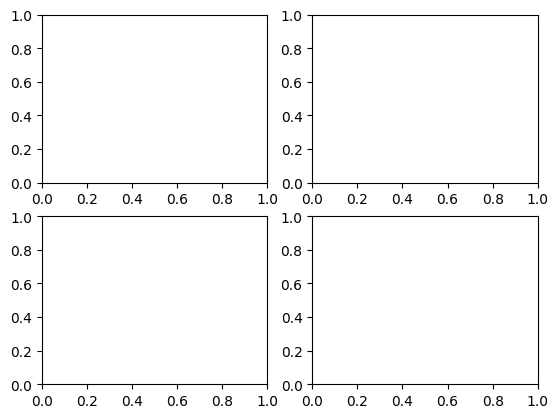

In [13]:
run_experiment('cuda')

In [ ]:
def run_experiment_mdp(device):
    lookup_freq = 1
    env, vec_expert = make_dummy_vec_env(name='pickplace', seq_len=200)
    val_env, _ = make_dummy_vec_env(name='pickplace', seq_len=200)

    transitions, rollouts = sample_expert_transitions(vec_expert.predict, env, 10)
    env.envs[0].reset_count = 0

    bc_trainer = bc.BC(
        observation_space=env.observation_space,
        action_space=env.action_space,
        demonstrations=transitions,
        device=device
    )

    tboard = TBoardGraphs(logname='BC pickplace 10 re', data_path='/data/bing/hendrik/gboard/')
    for i in range(10000):
        bc_trainer.train(n_epochs=20)
        success, rews = asd(env=env, learner=bc_trainer.policy)
        tboard.addTrainScalar('Reward', value=th.tensor(rews.mean()), stepid=i)
        tboard.addTrainScalar('Success Rate', value=th.tensor(success.mean()), stepid=i)

In [ ]:
run_experiment_mdp('cuda')